In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

Proje boyunca kullanacağımız gerekli kütüphaneleri içeri aktarıyoruz.
Son kısımdaki warnings filtresi python'un kodun çalışmasına engel olmayan, ama dikkat etmemizi isteyen bazı mesajları görmezden gelebilmeyi sağlamak için vardır.

In [3]:
data_dir = '/kaggle/input/corn-or-maize-leaf-disease-dataset/data'
ds_name = 'Leaf_Disease'

Veri klasörünü içeri aktarıyoruz ve datasetimizi isimlendiriyoruz.

In [4]:
def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

İçeri aktardığımız veri klasörünü hazır olarak direk kullanamayız. Bu yüzden klasör alt klasörlerine ayrılır, bütün alt klasörlerin dosyaları listelenir ve her bir dosyaya etiketler atanarak ayrıştırılır.

In [5]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

df_sample = df.sample(n=10, random_state=42).reset_index(drop=True)

print(tabulate(df_sample, headers='keys', tablefmt='fancy_grid', showindex=True))

╒════╤═══════════════════════════════════════════════════════════════════════════════════════════════╤════════════════╕
│    │ filepaths                                                                                     │ labels         │
╞════╪═══════════════════════════════════════════════════════════════════════════════════════════════╪════════════════╡
│  0 │ /kaggle/input/corn-or-maize-leaf-disease-dataset/data/Blight/Corn_Blight (742).JPG            │ Blight         │
├────┼───────────────────────────────────────────────────────────────────────────────────────────────┼────────────────┤
│  1 │ /kaggle/input/corn-or-maize-leaf-disease-dataset/data/Gray_Leaf_Spot/Corn_Gray_Spot (368).jpg │ Gray_Leaf_Spot │
├────┼───────────────────────────────────────────────────────────────────────────────────────────────┼────────────────┤
│  2 │ /kaggle/input/corn-or-maize-leaf-disease-dataset/data/Blight/Corn_Blight (792).JPG            │ Blight         │
├────┼──────────────────────────────────

pd.Series() fonksiyonu ile filepath ve label'ları pandas series haline getiriyor bunun yanı sıra pd.concat() ile iki series yan yana birleştiriliyor ve iki sütunlu bir dataframe ortaya çıkıyor. Yukarıdaki çıktı üzerinden de dataframe'in nasıl göründüğünü rahatlıkla anlayabiliyoruz.

The Leaf_Disease dataset has 4188 images.

The Leaf_Disease dataset has 4 classes

Class 'Common_Rust' has 1306 images


Class 'Blight' has 1146 images


Class 'Healthy' has 1162 images


Class 'Gray_Leaf_Spot' has 574 images




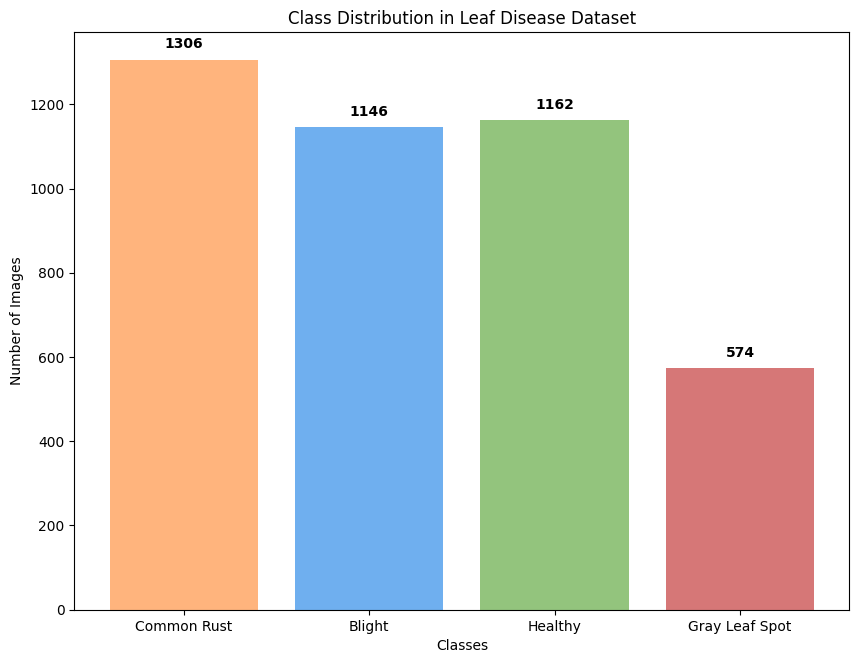

In [6]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")
    
num_of_examples(df, ds_name)
print()

def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")
    
num_of_classes(df, ds_name)

def classes_count(df, name='df'):
    
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('\n')
        
classes_count(df, ds_name)

class_num=len(df['labels'].unique())

# Sınıf isimleri ve örnek sayıları
classes = ['Common Rust', 'Blight', 'Healthy', 'Gray Leaf Spot']
counts = [1306, 1146, 1162, 574]

# Bar chart
plt.figure(figsize=(10,7.5))
bars = plt.bar(classes, counts, color=['#FFB47D','#6FAFEF','#93C47D','#D67777'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, yval, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Class Distribution in Leaf Disease Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

Yukarıda çıktıları bulunan hem yazılı metinlerle hem de grafikle beraber kaç sınıfımız olduğunu ve her bir sınıfın ne kadar görsele sahip olduğunu rahatlıkla gözlemleyebilirsiniz.

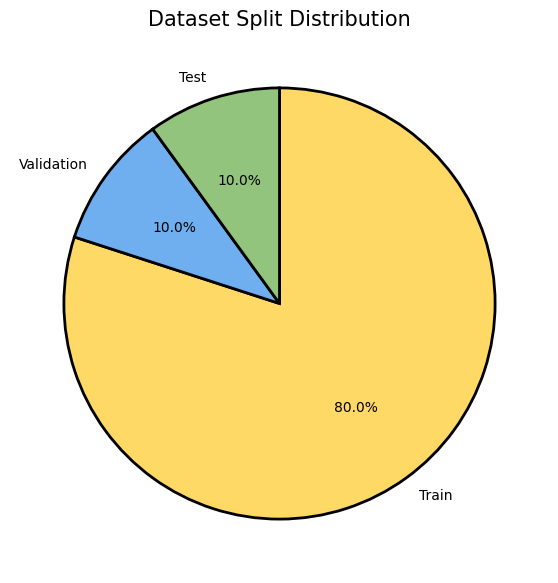

In [7]:
train_df, dummy_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 42)

valid_df, test_df = train_test_split(dummy_df, train_size= 0.5, shuffle= True, random_state= 42)

# Split sonrası veri sayıları
sizes = [len(train_df), len(valid_df), len(test_df)]
labels = ['Train', 'Validation', 'Test']
colors = ['#FFD966', '#6FAFEF', '#93C47D']

# Pasta grafiği
plt.figure(figsize=(7,7))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor':'black', 'linewidth':2}
)
plt.title("Dataset Split Distribution", fontsize=15)
plt.show()

Burada başlangıçta genel dataframe üzerinden train_df'ye %80'lik bir pay veriyoruz. Sonrasında kalan %20'lik kısmı valid_df ve test_df arasında yarı yarıya bölüştürüyoruz. Bunu yaparken de rastgeleliği sabit kılabilmek adına yazılım dünyasında artık meşhur bir değer olan random_state= 42 ifadesini kullanıyoruz. En son kısımda da pasta dilimi grafiğimizle bunu görselleştiriyoruz.

In [8]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.5, 1.2],
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator(
    rescale=1./255
)

# Train generator flow
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Validation generator flow
valid_gen = val_test_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,  
    batch_size=batch_size
)

# Test generator flow
test_gen = val_test_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,  
    batch_size=batch_size
)

Found 3350 validated image filenames belonging to 4 classes.
Found 419 validated image filenames belonging to 4 classes.
Found 419 validated image filenames belonging to 4 classes.


Bu kısımda ilk başta görsellerimizin hepsinin aynı değerlerle ölçeklendirilebilmesi için img_size, channels gibi değişkenlere atamalar yapıyoruz. Image_Data_Generator fonksiyonuyla beraber görseli çevirme, yakınlaştırma, döndürme gibi yollarla train veri setine augmentation ve preprocessing uygulanır fakat validation ve test veri setine yalnızca preprocessing uygulanır. Bunun uygulama kısmı flow_from_dataframe fonksiyonuyla gerçekleşmektedir. Ve bu kısımda görsellerin yeni hali generate edilir ve görsellerin yeni(preprocess, augment edilmiş) halleri train_gen, valid_gen ve test_gen değişkenlerine atanır. Burada aynı zaman da veri setlerine model boyunca kullanılacak batch_size değerleri verilir. One-hot encoding de |class_mode='categorical'| bu kısımda keras tarafından otomatik olarak gerçekleşmektedir. Son olarak da çıktı kısmında sırasıyla train, validation ve test veri setine kaç adet görsel düştüğü gözükmektedir. 

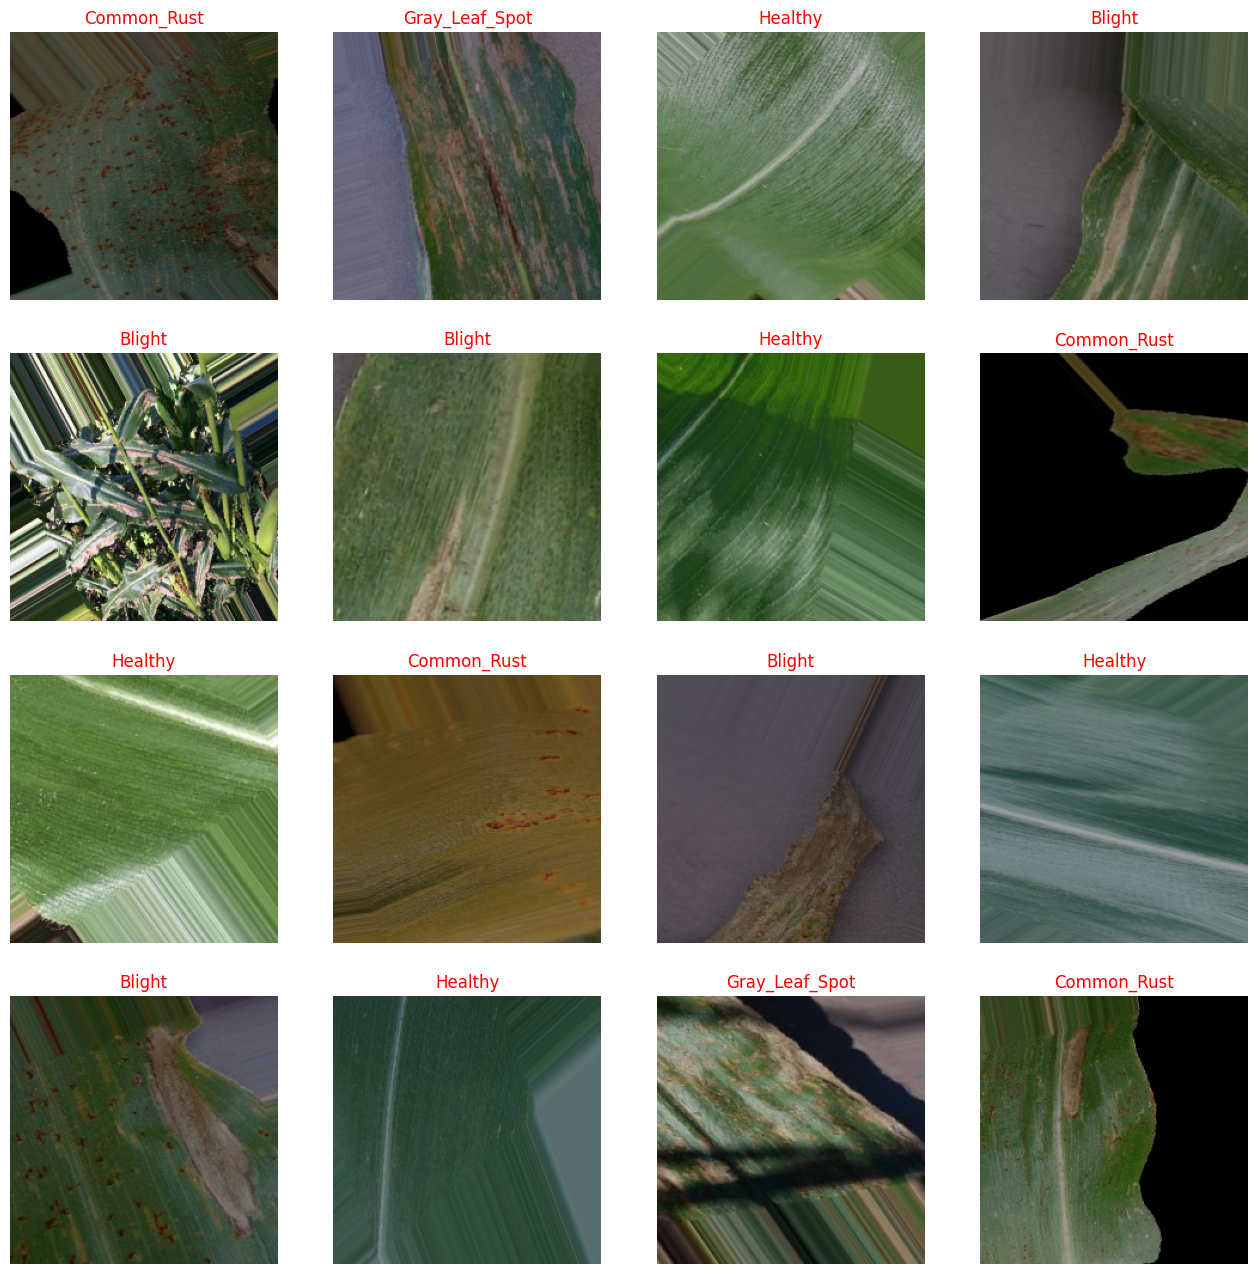

In [9]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (16, 16))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'red', fontsize= 12)
    plt.axis('off')
    
plt.show()

Bu kısımda train data setini görselleştiriyoruz ve augmentation yaptığımız için çevirme, döndürme, yakınlaştırma, karartma gibi değişikliklerin görsellere nasıl yansıdığını net bir şekilde görebiliyoruz.

In [12]:
results = {}

def create_cnn_model(dropout_rate=0.4):
    # CNN Modeli
    model = keras.Sequential([
    # 1. Conv Block
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    # 2. Conv Block
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    # 3. Conv Block
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    # Fully Connected
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_rate),
    
    # Output Layer
    keras.layers.Dense(class_num, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))
    ])

    return model

cnn_modelv1 = create_cnn_model()

cnn_modelv1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), #optimizer ve öğrenme oranı tercihi
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)  #eğitimin belli kıstasları karşılamaması durumunda erkenden süreci durduruyoruz.
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)  #val_loss verisine istinaden eğitim esnasında learning rate oranını düşürüyoruz.

# Modeli eğit
history = cnn_modelv1.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

results[f'val_accuracy_dropout(0.4)'] = history.history['val_accuracy'][-1]

for key, value in results.items():
    print(f"Son {key} değeri: {value:.4f}")

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6598 - loss: 1.3802 - val_accuracy: 0.2243 - val_loss: 2.1946 - learning_rate: 0.0010
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7709 - loss: 0.6389 - val_accuracy: 0.2196 - val_loss: 5.1930 - learning_rate: 0.0010
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8091 - loss: 0.5152 - val_accuracy: 0.2196 - val_loss: 7.4517 - learning_rate: 0.0010
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8407 - loss: 0.4310 - val_accuracy: 0.2196 - val_loss: 6.8643 - learning_rate: 5.0000e-04
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8533 - loss: 0.3922 - val_accuracy: 0.2220 - val_loss: 5.1108 - learning_rate: 5.0000e-04
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8673 - loss: 0.3763 - val_accuracy: 0.2243 - val_loss: 3.3807 - learning_rate: 2.5000e-04
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8728 - loss: 0.3710 - va

Bu kod bloğumuzda en başta sonuçların atanabilmesi adına result isimli bir dictionary oluşturuyoruz. Sonrasında keras ile oluşturacağımız cnn modelinin katmanlarını ve detay bilgilerini giriyoruz. Tanımladığımız fonksiyonda dropout değerini parametre olarak verdik çünkü projenin ilerleyen kısımlarında hiperparametre optimizasyonlarını gösterebilmek adına farklı bir dropout değeri ile modeli tekrar eğiteceğiz. Modele ait detayları tanımlarken L2 Regularization, dropout, ve batch normalization gibi teknikleri kullanıyoruz bunları kullanmamızın ana sebepleri overfittinge veya underfitting durumlarına engel olmak ve modeli daha doğru, stabil bir şekilde eğitebilmek. Model fonksiyonumuzu tanımladıktan sonra optimizer olarak Adam methodunu seçiyoruz ve veri setimizin büyüklüğüne bağlı olarak learning rate'i belirliyoruz. Hemen bir alt satırında da daha önce one hot encoding işlemini gerçekleştirdiğimiz ve veri setimiz multi-class bir yapıya sahip olduğu için categorical_crossentropy kullanıyoruz. Sonrasında da şayet modeli yüksek epoch'larla eğitecek olursak zaman kaybı oluşmaması ve daha verimli sonuçlar elde edebilmek adına early_stop ve reduce_lr kısıtlamalarını tanımlıyoruz. Artık modeli eğitmeye başlıyoruz ve sonuçlarını history isimli değişkene tanımlıyoruz. Son kısımda da history'de tutulan kayıtların son val_accuracy değerini başta tanımlamış olduğumuz results dictionary'sine atıyoruz ve bunu yazdırıyoruz.

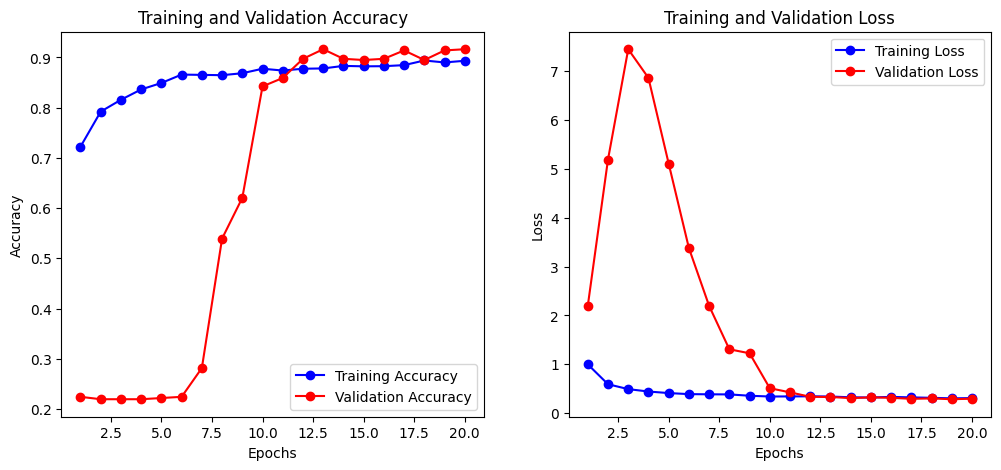

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

# Accuracy grafiği
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Modelimiz eğitildikten ve sonuçlar kaydedildikten sonra burada acc, val_acc, loss, val_loss değişkenlerine sonuçları atıyoruz. Sonrasında bu sonuçların accuracy ve loss grafiklerini oluşturuyoruz. Grafiklere bakarak şunu görebiliyoruz ki accuracy-val_accuracy'nin artış, loss ve val_loss'un düşüş değerlerindeki doğrusal ve sürekli değişimlere dayanarak model düzgün bir biçimde eğitilmiş ve herhangi bir overfitting veya underfitting'e uğramamıştır.

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - accuracy: 0.9231 - loss: 0.2566

Test Kaybı: 0.2420
Test Doğruluğu: 0.9212

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step

Sınıflandırma Raporu:
                precision    recall  f1-score   support

   Common_Rust       0.89      0.85      0.87       109
        Blight       0.97      0.94      0.95       142
       Healthy       0.77      0.87      0.82        61
Gray_Leaf_Spot       0.99      1.00      1.00       107

      accuracy                           0.92       419
     macro avg       0.90      0.91      0.91       419
  weighted avg       0.92      0.92      0.92       419



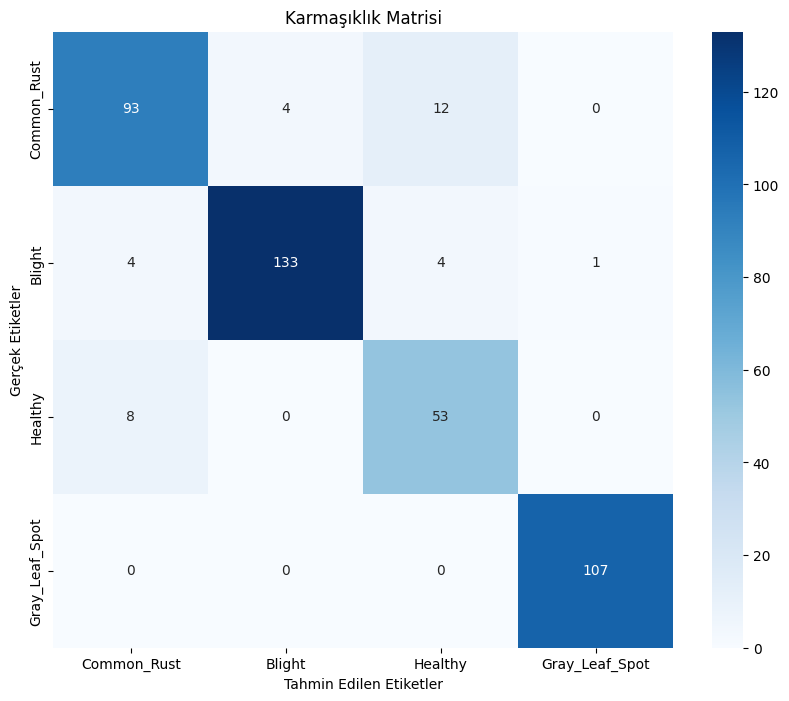

In [14]:
class_names = df['labels'].unique()

# Test seti üzerinde modeli değerlendirelim
test_loss, test_accuracy = cnn_modelv1.evaluate(test_gen, verbose=1)
print(f"\nTest Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}\n")

# Tahminlerde bulunalım
y_pred = cnn_modelv1.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# test_gen'deki gerçek etiketler
y_true = test_gen.classes

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiketler')
plt.xlabel('Tahmin Edilen Etiketler')
plt.show()

Bu kısımda artık eğitilmiş olan modelimizi test verileriyle değerlendiriyoruz ve test_loss, test_accuracy sonuçlarına ulaşıyoruz. Sonrasında eğitilen modelimiz ile tahmin gerçekleştirip verilen oranların içerisinden en yükseğini seçip tahmin edilen classlar'ı y_pred_classes'a atıyoruz. Bir sonraki adımda classification_report fonksiyonuna tahmin edilen sınıfları ve gerçek sınıfları isimleri ile beraber parametre olarak verip çıkan sonuçta f1-score, recall ve precision değerlerini sınıf sınıf görüntüleyebiliyoruz. En son kısımda da karmaşıklık matrisini tahminler ve gerçek veriler üzerinden oluşturuyoruz. Bu matris bize her bir sınıftan yapılan tahminlerin kaç tanesinin doğru olduğunu veya yanlış yapıldıysa da diğer classlardan hangilerini daha çok benzeterek yanlış yaptığını sayısal veriler üzerinden görmemizi sağlıyor.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,740,942 (254.60 MB)

 Trainable params: 22,246,660 (84.86 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 44,493,322 (169.73 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


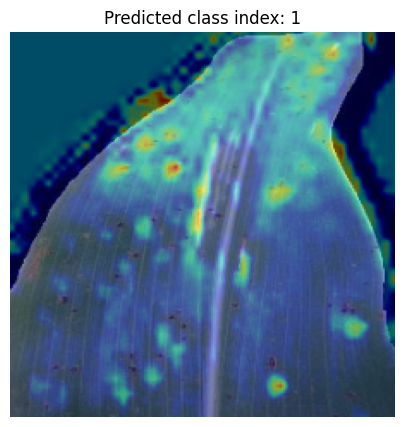

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


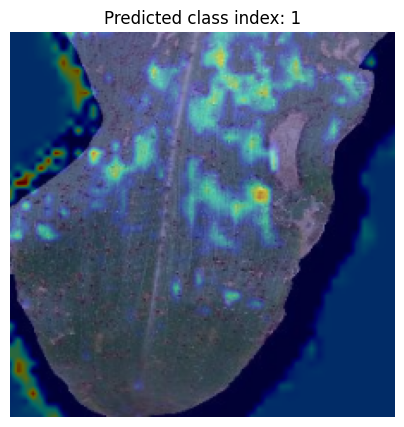

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


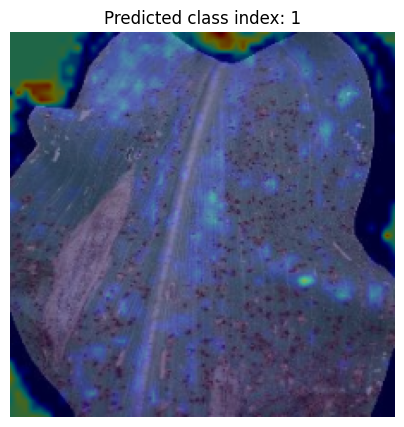

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


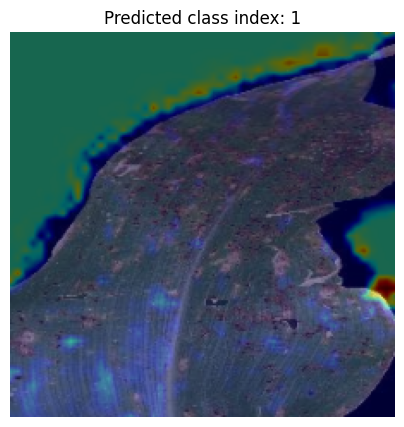

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


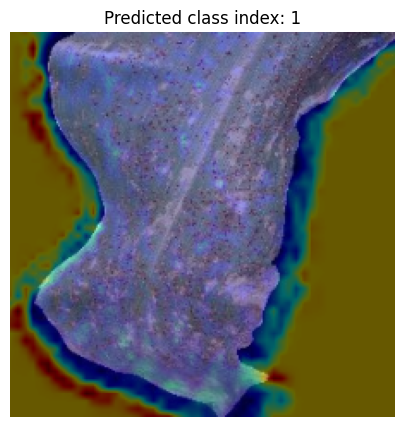

In [39]:
cnn_modelv1.summary()

# Grad-CAM nesnesini oluştur
gradcam = Gradcam(model=cnn_modelv1, clone=False)  # clone=False ile model kopyalanmaz, mevcut model kullanılır

# Son conv katmanı
last_conv_layer_name = "conv2d_8"

for i in range(5):
    img_path = df['filepaths'].iloc[i]

    # Resmi yükle ve preprocess et
    img = tf.keras.utils.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Tahmin yap
    preds = cnn_modelv1.predict(img_array)
    pred_class = np.argmax(preds[0])

    # Score fonksiyonu: modelin tahmin ettiği sınıfın outputunu kullan
    score = lambda output: output[:, pred_class]

    # Gradcam haritasını oluştur
    cam = gradcam(score, img_array, penultimate_layer=last_conv_layer_name)

    heatmap = np.uint8(255 * cam[0])
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img_orig = cv2.imread(img_path)
    img_orig = cv2.resize(img_orig, (224,224))
    superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted class index: {pred_class}")
    plt.axis("off")
    plt.show()

Bu kısımda gradcam çalışması yapabilmemiz için son conv layer'ın ismi gerekiyor o yüzden başta modelin özetini istiyoruz. Sonrasında "from tf_keras_vis.gradcam import Gradcam" ilk kısımda import ettiğimiz Gradcam class'ının bir örnek nesnesini oluşturuyoruz. Bir de bu class'ı import edebilmemiz için "!pip install tf-keras-vis" bu package'ın yüklenmesi gerekmektedir. Nesnemizi oluşturduktan sonra ilk 5 örneğimizin ısı haritası ile beraber olan resmini oluşturabilmek için for döngümüzü kuruyoruz döngünün ilk kısmında resme preprocessing uyguluyoruz modelin tahmin yapabilmesi için, tahmin edilen class'ı pred_class'a eşitliyoruz. Sonrasında gradcam nesnesini çağırdığımızda lazım olacak olan score fonksiyonunu lambda ile tek satırda tanımlıyoruz ardından diğer gerekli parametreleri de vererek gradcam nesnesini çağırıp sonucunu cam'a eşitliyoruz ve gradcam haritasını oluşturuyoruz. Son olarak da heatmapimizi tek resim olduğu için "cam[0]" ile tanımlıyoruz. En son kısımda da heatmap ve orijinal resmi; %60 resim, %40 heatmap olacak şekilde üst üste bindiriyoruz.

In [15]:
cnn_modelv2 = create_cnn_model(0.6)

cnn_modelv2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = cnn_modelv2.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Son epoch validation accuracy'i kaydet
results[f'val_accuracy_dropout(0.6)'] = history.history['val_accuracy'][-1]

# Sonuçları yazdır
for key, value in results.items():
    print(f"Son {key} değeri: {value:.4f}")

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6607 - loss: 1.3686 - val_accuracy: 0.2220 - val_loss: 3.1974 - learning_rate: 0.0010
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7813 - loss: 0.6665 - val_accuracy: 0.2196 - val_loss: 3.3709 - learning_rate: 0.0010
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7962 - loss: 0.5809 - val_accuracy: 0.2196 - val_loss: 3.6260 - learning_rate: 0.0010
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8174 - loss: 0.5318 - val_accuracy: 0.2243 - val_loss: 3.5756 - learning_rate: 5.0000e-04
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8197 - loss: 0.5226 - val_accuracy: 0.2291 - val_loss: 3.0729 - learning_rate: 5.0000e-04
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8448 - loss: 0.4154 - val_accuracy: 0.3126 - val_loss: 2.4066 - learning_rate: 5.0000e-04
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8402 - loss: 0.4647 - va

Daha önce cnn modelini oluşturduğumuz kısımda hiperparametre optimizasyonu olarak bahsettiğim kısmı burada gerçekleştiriyoruz. Bu sefer modeli artık default dropout değeri olan "0.4" üzerinden değil de "0.6" değeriyle eğitiyoruz. Sonrasında history'e kaydedilen son val_accuracy değerini çekiyoruz ve en son kısımda aynı results dictionary'sine atamış olduğumuz sonuç değerlerini hem dropout(0.4) için hem de dropout(0.6) için yazdırıyoruz. Çıktılara bakarak modelimizin hangi dropout oranıyla daha iyi bir sonuç verdiğini gözlemleyebiliyoruz.

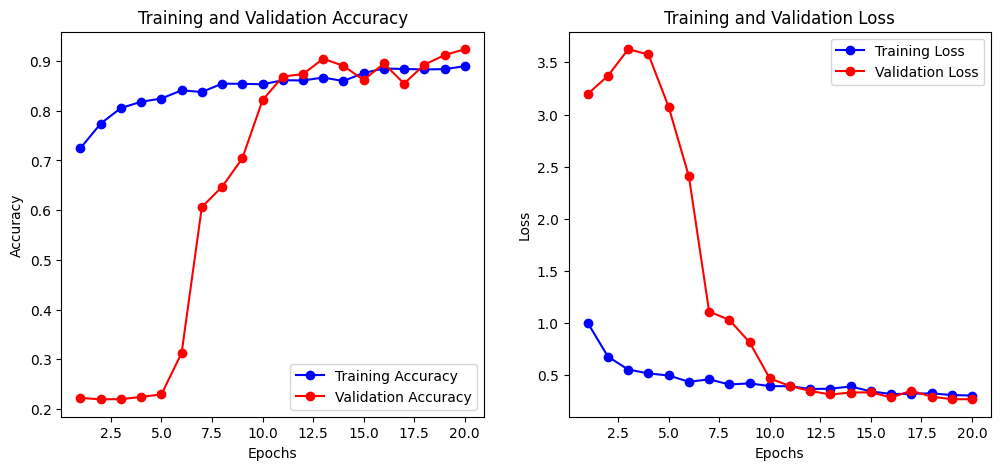

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

# Accuracy grafiği
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Bu kısımda daha önce de kullanmış olduğumuz accuracy ve loss grafiklerini bu sefer dropout(0.6) ile çalışan cnn_modelv2 için oluşturuyoruz ve şunu görüyoruz ki bu model dropout(0.4) olan modelden çok daha stabil bir şekilde seyir ediyor.